<a href="https://colab.research.google.com/github/elektromusik/Applied_Statistics_and_ML/blob/main/Decision_Tree_Random_Forest_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Implementation of Decision Tree, Random Forest & XGBoost

In [63]:
"""
Implementation and Tuning of Tree-Based Classifiers:
Decision Tree, Random Forest & XGBoost
----------------------------------------

Binary classification on the Credit Risk dataset
from https://www.kaggle.com/datasets/laotse/credit-risk-dataset

Models:
  I)   Decision Tree
  II)  Random Forest (OOB + isotonic calibration)
  III) XGBoost (early stopping)

Metrics:
  - Accuracy, ROC-AUC, PR-AUC, F1, Log-Loss
  - Best-F1 threshold, OOB-AUC for RF
  - Reliability plot (RF calibration)

Author: Dr. Leonard Pleschberger
Date  : August 19, 2025
""";

## I. Import Libraries

In [64]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.text import Text, Annotation
from scipy import sparse
from scipy.stats import randint
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     StratifiedKFold, train_test_split)
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.isotonic import IsotonicRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibrationDisplay, calibration_curve
from sklearn.metrics import (accuracy_score, roc_auc_score,
                             average_precision_score,
                             f1_score, log_loss, confusion_matrix)
from xgboost import XGBClassifier
import xgboost as xgb

# _____ Config _____
RANDOM_STATE = 42

## II. Load, Split and Preprocess the Data

In [65]:
df = pd.read_csv("credit_risk_dataset.csv")

X = df.drop(columns=["loan_status"])
# Simple target: Only value 1 -> 1, everything else -> 0
y = (pd.to_numeric(df["loan_status"], errors="coerce") == 1).astype(int)

# Test split; stratisfy => Class 0, 1 proportion is preserved
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE)

# Calibration/validation split out of training data
X_train, X_cal, y_train, y_cal = train_test_split(
    X_train_full, y_train_full, test_size=0.20,
    stratify=y_train_full, random_state=RANDOM_STATE)

# Preprocessing
d_types = ["object", "category", "bool"]
cat_cols = X.select_dtypes(include=d_types).columns.tolist()
num_cols = X.columns.difference(cat_cols).tolist()

# Impute numbers in num cols
num_imputer = SimpleImputer(strategy="median")
X_num_train = num_imputer.fit_transform(X_train[num_cols])
X_num_cal   = num_imputer.transform(X_cal[num_cols])
X_num_test  = num_imputer.transform(X_test[num_cols])

# Impute values in cat cols
cat_imputer = SimpleImputer(strategy="most_frequent")
X_cat_train_imp = pd.DataFrame(
    cat_imputer.fit_transform(X_train[cat_cols]),
    columns=cat_cols, index=X_train.index)

X_cat_cal_imp = pd.DataFrame(
    cat_imputer.transform(X_cal[cat_cols]),
    columns=cat_cols, index=X_cal.index)

X_cat_test_imp = pd.DataFrame(
    cat_imputer.transform(X_test[cat_cols]),
    columns=cat_cols, index=X_test.index)

# One-Hot-Encoding: Create a binary col for each different category class
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
except TypeError:  # sklearn < 1.2
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

X_cat_train = ohe.fit_transform(X_cat_train_imp)
X_cat_cal   = ohe.transform(X_cat_cal_imp)
X_cat_test  = ohe.transform(X_cat_test_imp)

# Merge num and cat cols
X_train_sparse = sparse.hstack([X_num_train, X_cat_train]).tocsr()
X_cal_sparse   = sparse.hstack([X_num_cal,   X_cat_cal]).tocsr()
X_test_sparse  = sparse.hstack([X_num_test,  X_cat_test]).tocsr()

# Convert to dense
to_dense = lambda A: A.toarray() if sparse.issparse(A) else A
X_train_dense, X_cal_dense, X_test_dense = map(
    to_dense, [X_train_sparse, X_cal_sparse, X_test_sparse])

# Feature names (for plots)
cat_features = ohe.get_feature_names_out(cat_cols).tolist()
feature_names = num_cols + cat_features

## III. Fitting and Tuning the Decision Tree Model

In [66]:
# Cross validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
scoring = "roc_auc"  # For binary classification;
                     # switch to "accuracy" if preferred

dt_base = DecisionTreeClassifier(random_state=RANDOM_STATE)

# Grid Search
param_grid = {
    "max_depth": [None, 5, 10, 20, 30],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10],
    "criterion": ["gini", "entropy"],
    "class_weight": [None, "balanced"]}

grid = GridSearchCV(
    estimator=dt_base,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    verbose=1)

grid.fit(X_train_dense, y_train)

best_dt_grid = grid.best_estimator_
proba_g = best_dt_grid.predict_proba(X_test_dense)[:, 1]
pred_g  = (proba_g >= 0.5).astype(int)

print("\n--- Grid Search ---")
print("Best params    :", grid.best_params_)
print(f"Best CV {scoring}: {grid.best_score_:.4f}")
print(f"Test ROC-AUC   : {roc_auc_score(y_test, proba_g):.4f}")
print(f"Test Accuracy  : {accuracy_score(y_test, pred_g):.4f}")
print(f"Test F1 (0.5)  : {f1_score(y_test, pred_g):.4f}")

Fitting 3 folds for each of 320 candidates, totalling 960 fits

--- Grid Search ---
Best params    : {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 20}
Best CV roc_auc: 0.9077
Test ROC-AUC   : 0.9052
Test Accuracy  : 0.9122
Test F1 (0.5)  : 0.7837


## IV. Fitting the [calibrated] Random Forest Model

In [67]:
# Fitting Random Forest (dense, OOB)
random_forest = RandomForestClassifier(
    n_estimators=500,
    max_features="sqrt",
    min_samples_leaf=10,
    class_weight="balanced_subsample",
    oob_score=True,
    n_jobs=3,
    random_state=RANDOM_STATE)

random_forest.fit(X_train_dense, y_train)

# OOB AUC on training (from OOB decision function)
try:
    oob_proba = random_forest.oob_decision_function_[:, 1]
    oob_auc = roc_auc_score(y_train, oob_proba)
    print(f"OOB-AUC (train): {oob_auc:.4f}")
except Exception:
    print("OOB-AUC not available.")

# Isotonic Calibration
proba_rf_calib_raw = random_forest.predict_proba(X_cal_sparse)[:, 1]
iso_cal = IsotonicRegression(out_of_bounds="clip")
iso_cal.fit(proba_rf_calib_raw, y_cal);

OOB-AUC (train): 0.9272


## V. Fitting XGBoost (with Early Stopping)

In [68]:
# Weighting against class imbalancing
pos = int(y_train.sum())
neg = int(len(y_train) - pos)
scale_pos_weight = neg / max(pos, 1)

dtrain = xgb.DMatrix(X_train_sparse, label=y_train)
dvalid = xgb.DMatrix(X_test_sparse, label=y_test)

# Handle class imbalance via weighting:
pos = int(y_train.sum())
neg = int(len(y_train) - pos)
scale_pos_weight = neg / max(pos, 1)

params = { "objective": "binary:logistic",
          "eval_metric": "auc",
           "eta": 0.05,
           "max_depth": 6,
           "subsample": 0.8,
           "colsample_bytree": 0.8,
           "lambda": 1.0,
           "scale_pos_weight": scale_pos_weight,
           "verbosity": 0}

boost = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    early_stopping_rounds=100,
    verbose_eval=False)

## V. Evaluation

In [69]:
def evaluate(name, y_true, proba):
    eps = 1e-15
    proba = np.clip(proba, eps, 1 - eps)
    y_hat = (proba >= 0.5).astype(int)
    print(f"\n___ {name} ___")
    print(f"Accuracy : {accuracy_score(y_true, y_hat):.4f}")
    print(f"ROC-AUC  : {roc_auc_score(y_true, proba):.4f}")
    print(f"PR-AUC   : {average_precision_score(y_true, proba):.4f}")
    print(f"F1 at 0.5: {f1_score(y_true, y_hat):.4f}")
    print(f"Log-Loss : {log_loss(y_true, proba):.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_hat))
    ths = np.linspace(0.05, 0.95, 19)
    f1s = [f1_score(y_true, (proba >= t).astype(int)) for t in ths]
    best_idx = int(np.argmax(f1s))
    print(f"Best F1  : {max(f1s):.4f} at threshold {ths[best_idx]:.2f}")

# Decision Tree (tuned)
proba_dt = best_dt_grid.predict_proba(X_test_dense)[:, 1]
evaluate("Decision Tree (tuned)", y_test, proba_dt)

# Random Forest (uncalibrated + OOB)
proba_rf_base = random_forest.predict_proba(X_test_sparse)[:, 1]
evaluate("Random Forest (uncalibrated)", y_test, proba_rf_base)
print(f"RF OOB score: {random_forest.oob_score_:.4f}")

# Random Forest (calibrated via isotonic on CALIB)
proba_rf_cal = iso_cal.predict(proba_rf_base)
evaluate("Random Forest (calibrated, isotonic)", y_test, proba_rf_cal)

# XGBoost (native booster API)
dtest = xgb.DMatrix(X_test_sparse, label=y_test)
proba_xgb = boost.predict(dtest)  # already probability output
evaluate("XGBoost (early-stopped, native API)", y_test, proba_xgb)



___ Decision Tree (tuned) ___
Accuracy : 0.9122
ROC-AUC  : 0.9052
PR-AUC   : 0.8368
F1 at 0.5: 0.7837
Log-Loss : 0.4554
Confusion Matrix:
 [[4909  186]
 [ 386 1036]]
Best F1  : 0.8121 at threshold 0.85

___ Random Forest (uncalibrated) ___
Accuracy : 0.9112
ROC-AUC  : 0.9256
PR-AUC   : 0.8734
F1 at 0.5: 0.7875
Log-Loss : 0.2766
Confusion Matrix:
 [[4865  230]
 [ 349 1073]]
Best F1  : 0.8092 at threshold 0.60
RF OOB score: 0.9108

___ Random Forest (calibrated, isotonic) ___
Accuracy : 0.9267
ROC-AUC  : 0.9245
PR-AUC   : 0.8594
F1 at 0.5: 0.8066
Log-Loss : 0.2330
Confusion Matrix:
 [[5042   53]
 [ 425  997]]
Best F1  : 0.8101 at threshold 0.40

___ XGBoost (early-stopped, native API) ___
Accuracy : 0.9262
ROC-AUC  : 0.9477
PR-AUC   : 0.9044
F1 at 0.5: 0.8213
Log-Loss : 0.2000
Confusion Matrix:
 [[4931  164]
 [ 317 1105]]
Best F1  : 0.8321 at threshold 0.70


## VI. Visualization of a Tree

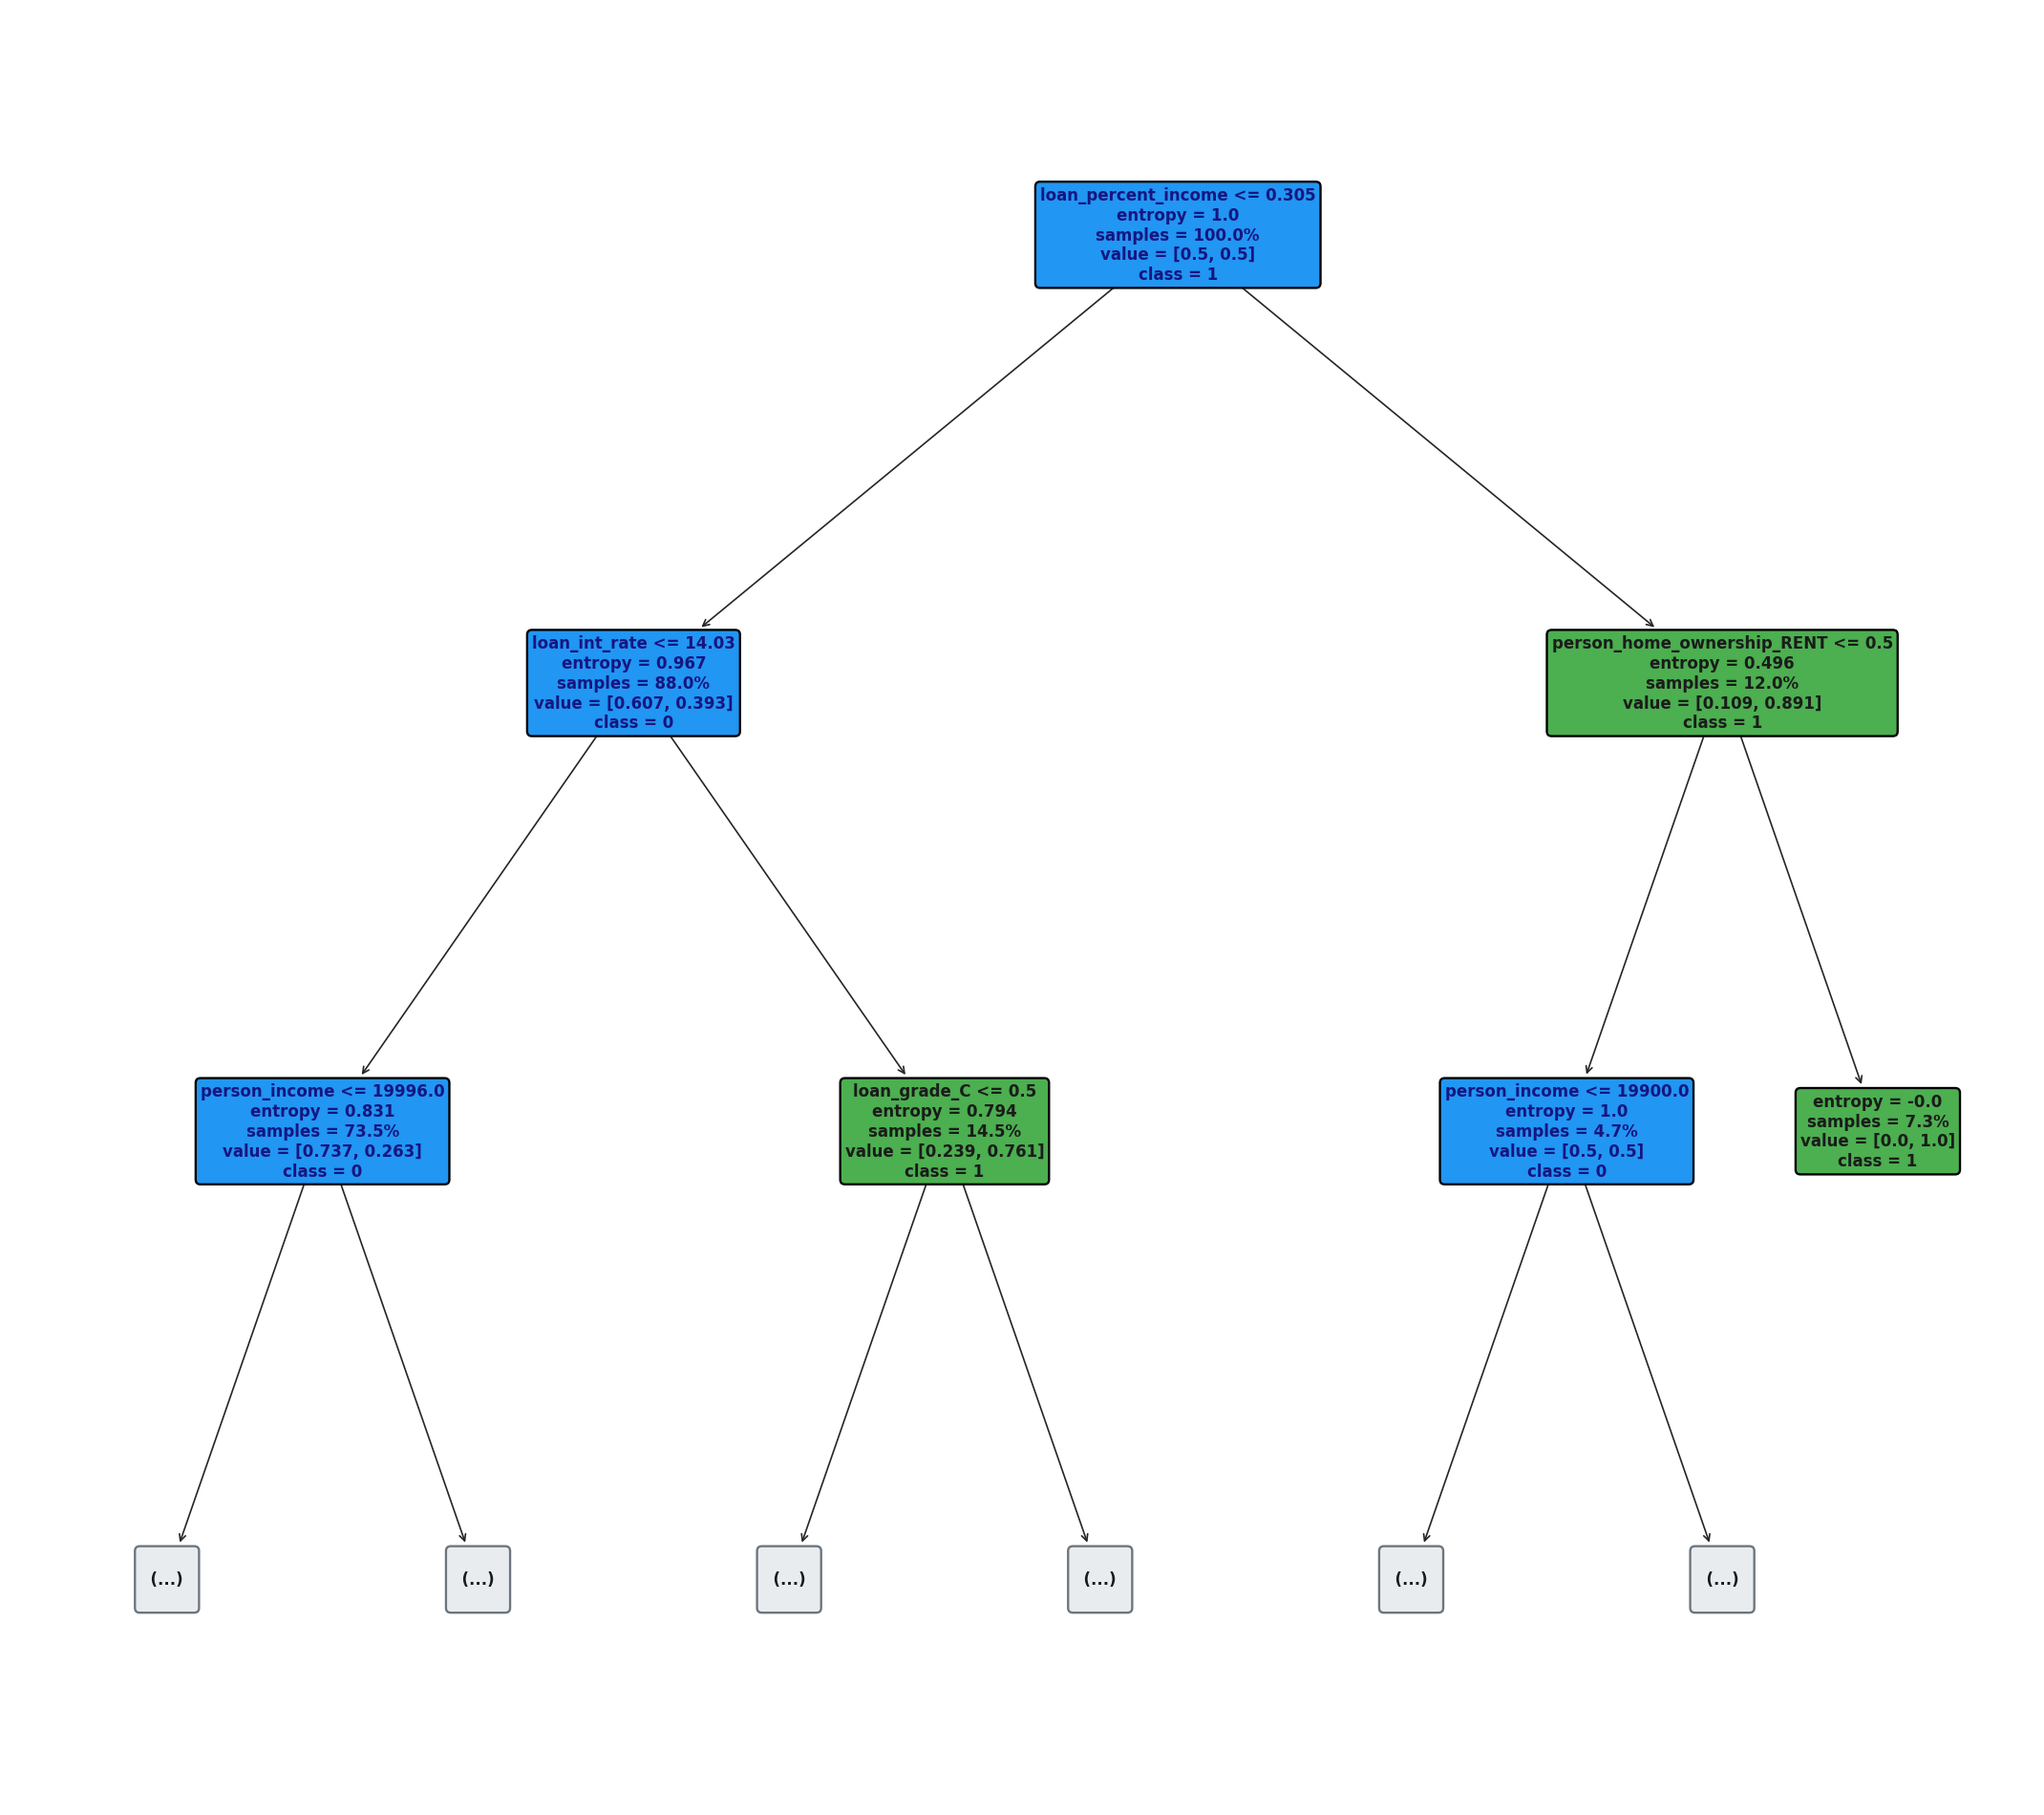

In [70]:
MAX_DEPTH = 2
fig, ax = plt.subplots(figsize=(18, 16))

artists = plot_tree(
    best_dt_grid,
    max_depth=MAX_DEPTH,
    filled=True,
    rounded=True,
    proportion=True,
    feature_names=feature_names,
    class_names=["0", "1"],
    fontsize=9,
    ax=ax)

# Remove True/False edge texts (cosmetic)
edge_texts = [
    a for a in artists
    if isinstance(a, (Text, Annotation)) and a.get_bbox_patch() is None]

for et in edge_texts:
    if et.get_text().strip() in {"True", "False"}:
        et.remove()

# Optional recoloring kept (safe)
patches_ordered, texts_ordered, seen = [], [], set()
for a in artists:
    if isinstance(a, Text):
        patch = a.get_bbox_patch()
        if patch is None:
            continue
        pid = id(patch)
        if pid in seen:
            continue
        seen.add(pid)
        patches_ordered.append(patch)
        texts_ordered.append(a)

face0, edge0, txt0 = "#2196f3", "#000000", "#161680" # Erste blue
face1, edge1, txt1 = "#4caf50", "#000000", "#1A1C1A" # HTC green
neutral_face, neutral_edge = "#e9ecef", "#6c757d"

val_re = re.compile(r"value\s*=\s*\[([0-9.,\s]+)\]")
for patch, txt in zip(patches_ordered, texts_ordered):
    node_text = txt.get_text() or ""
    m = val_re.search(node_text)
    if m:
        counts = [float(x) for x in m.group(1).replace(" ", "").split(",") if x]
        if len(counts) >= 2:
            majority = int(np.argmax(counts[:2]))
            if majority == 1:
                patch.set_facecolor(face1); patch.set_edgecolor(edge1); txt.set_color(txt1)
            else:
                patch.set_facecolor(face0); patch.set_edgecolor(edge0); txt.set_color(txt0)
        else:
            patch.set_facecolor(neutral_face); patch.set_edgecolor(neutral_edge); txt.set_color("0.1")
    else:
        patch.set_facecolor(neutral_face); patch.set_edgecolor(neutral_edge); txt.set_color("0.1")
    patch.set_linewidth(1.4)
    txt.set_fontsize(10)
    txt.set_fontweight("bold")

plt.tight_layout()
plt.show()

## VII. Reliability Plot (Calibration Curve)

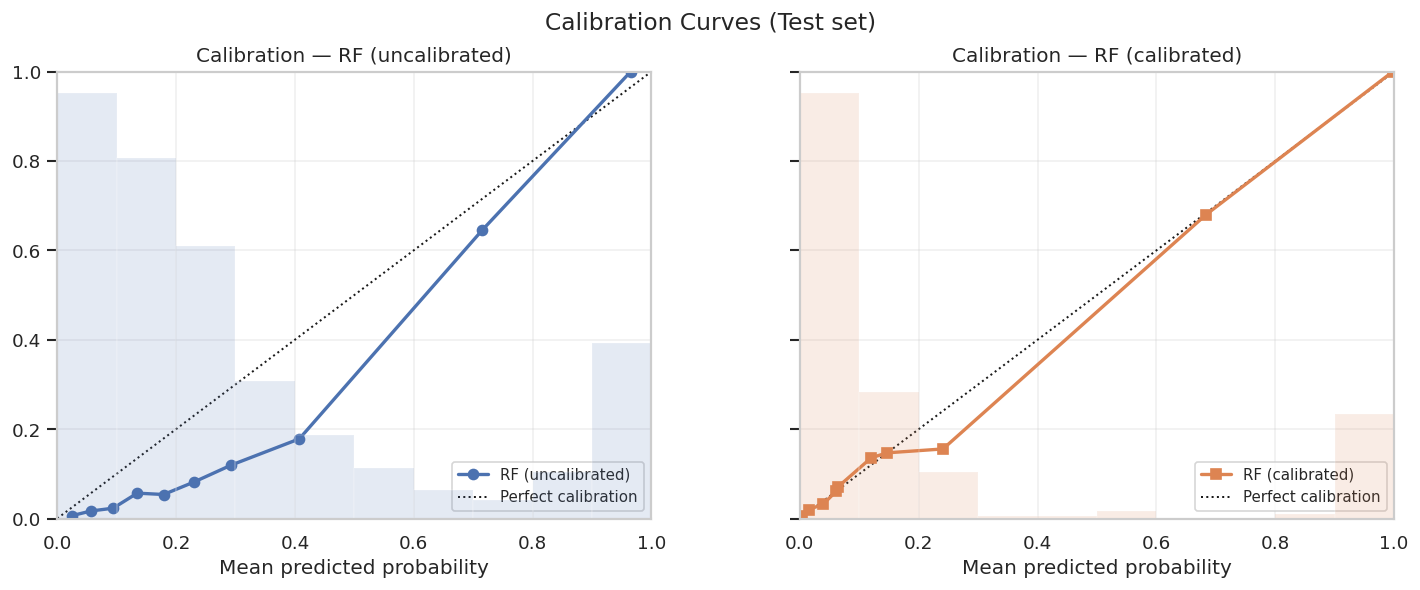

In [71]:
sns.set(style="whitegrid", rc={"figure.dpi": 120})

# Compute calibration points (prob_true, prob_pred = fraction of positives,
# mean predicted prob)
prob_true_uncal, prob_pred_uncal = calibration_curve(y_test,
                                                     proba_rf_base,
                                                     n_bins=10,
                                                     strategy="quantile")
prob_true_cal,   prob_pred_cal   = calibration_curve(y_test,
                                                     proba_rf_cal,
                                                     n_bins=10,
                                                     strategy="quantile")

# Create side-by-side subplots
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=True)

# Left: Uncalibrated
ax = axes[0]
ax.plot(prob_pred_uncal,
        prob_true_uncal,
        marker='o',
        linestyle='-',
        linewidth=2,
        markersize=6,
        label='RF (uncalibrated)',
        zorder=3)
ax.plot([0, 1], [0, 1], 'k:',
        linewidth=1.2,
        label='Perfect calibration',
        zorder=1)
ax.set_title('Calibration — RF (uncalibrated)', fontsize=12)
ax.set_xlabel('Mean predicted probability')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xticks(np.linspace(0, 1, 6))
ax.set_yticks(np.linspace(0, 1, 6))
ax.legend(loc='lower right', fontsize=9)
ax.grid(True, alpha=0.3)

# Optionally add a small histogram of predicted probs
# along the x-axis (transparent)
ax_hist = ax.twinx()
ax_hist.hist(proba_rf_base, bins=10, range=(0, 1), alpha=0.15, density=True)
ax_hist.set_yticks([])                      # hide histogram y-axis ticks
ax_hist.set_ylim(0, ax_hist.get_ylim()[1])  # keep histogram in visible range

# Right: Calibrated
ax = axes[1]
ax.plot(prob_pred_cal,
        prob_true_cal,
        marker='s',
        linestyle='-',
        linewidth=2,
        markersize=6,
        label='RF (calibrated)',
        color='C1',
        zorder=3)
ax.plot([0, 1], [0, 1], 'k:',
        linewidth=1.2, label='Perfect calibration', zorder=1)
ax.set_title('Calibration — RF (calibrated)', fontsize=12)
ax.set_xlabel('Mean predicted probability')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xticks(np.linspace(0, 1, 6))
ax.grid(True, alpha=0.3)
ax.legend(loc='lower right', fontsize=9)

ax_hist = ax.twinx()
ax_hist.hist(proba_rf_cal, bins=10, range=(0, 1),
             alpha=0.15, density=True, color='C1')
ax_hist.set_yticks([])

# Overall adjustments
plt.suptitle("Calibration Curves (Test set)", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.88, wspace=0.25)
plt.show()